In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.ensemble import RandomForestClassifier as SklearnRFC
from sklearn.tree import DecisionTreeClassifier as SklearnDTC
from sklearn.neighbors import KNeighborsClassifier as SklearnKNN
from sklearn.linear_model import LogisticRegression as SklearnLR

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from models import *

In [4]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [7]:
df.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

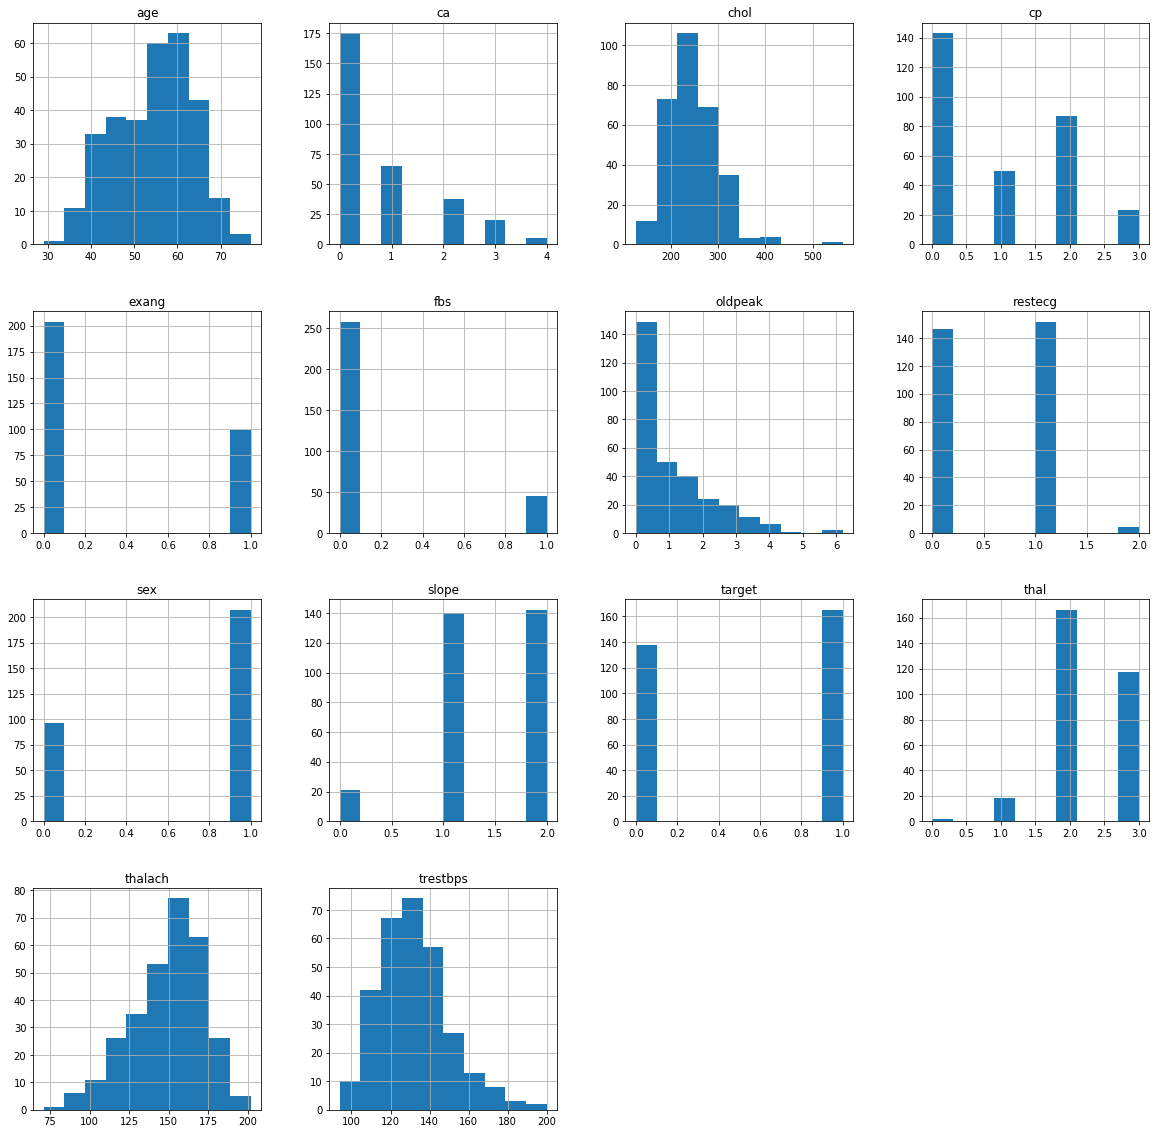

In [8]:
df.hist(figsize = (20,20))
plt.show()

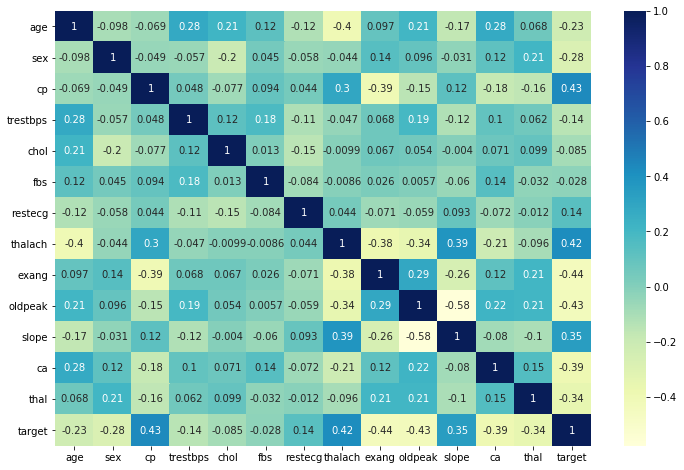

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

In [10]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [11]:
X, y = df.drop(["fbs"], axis=1), df["fbs"]

In [12]:
X.head(7)

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,153,0,1.3,1,0,2,1


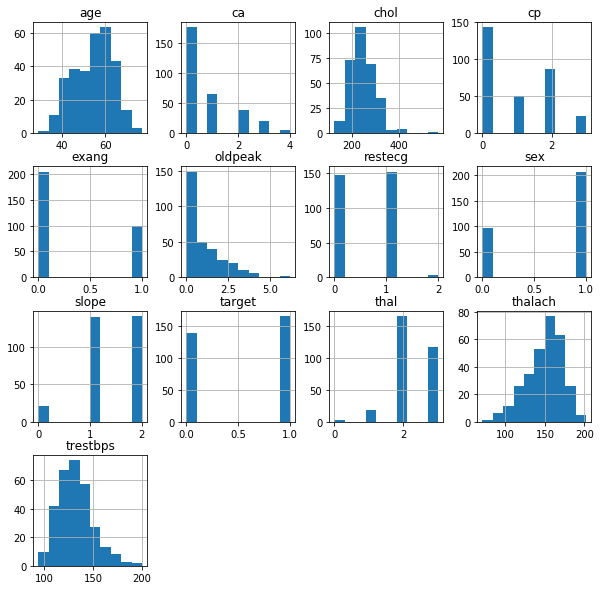

In [13]:
X.hist(figsize = (10,10))
plt.show()

In [14]:
def cv_score(clf, X, y, k_folds=5, average='macro'):
    kf = StratifiedKFold(n_splits=k_folds, random_state=123, shuffle=True)
    scores = np.zeros(k_folds)    
    for i, (train_index, val_index) in enumerate(kf.split(X, y)):
        # numpy required in case of algos realisation
        X_train, y_train = X.loc[train_index].to_numpy(), y.loc[train_index].to_numpy()
        X_val, y_val = X.loc[val_index].to_numpy(), y.loc[val_index].to_numpy()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        scores[i] = f1_score(y_val, y_pred, average=average)
    return scores

In [15]:
%%time
rf = RandomForestClassifier()
scores = cv_score(rf, X, y)
print("Случайный лес")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Случайный лес
Accuracy: 0.46 (+/- 0.00)
Wall time: 11 s


In [16]:
%%time
s_rf = SklearnRFC()
scores = cv_score(s_rf, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.46 (+/- 0.01)
Wall time: 713 ms


In [17]:
%%time
knn = KNN(n_neighbors=5)
scores = cv_score(knn, X, y)
print("KNN")
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KNN
F1: 0.45 (+/- 0.01)
Wall time: 25.9 ms


In [18]:
%%time
s_knn = SklearnKNN(n_neighbors=5)
scores = cv_score(s_knn, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.45 (+/- 0.01)
Wall time: 29.9 ms


In [23]:
%%time
dtc = DecisionTreeClassifier(max_depth=5)
scores = cv_score(dtc, X, y)
print("Решающее дерево")
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Решающее дерево
F1: 0.45 (+/- 0.01)
Wall time: 532 ms


In [20]:
%%time
s_dtc = SklearnDTC(max_depth=5)
scores = cv_score(s_dtc, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.45 (+/- 0.01)
Wall time: 17 ms


In [21]:
%%time
lr = LogisticRegression()
scores = cv_score(lr, X, y)
print("Логистическая регрессия")
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Логистическая регрессия
F1: 0.44 (+/- 0.07)
Wall time: 113 ms


In [22]:
%%time
s_lr = SklearnLR()
scores = cv_score(s_lr, X, y)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1: 0.46 (+/- 0.00)
Wall time: 90.8 ms
